# 1 Introduction

In this lesson, you will continue to discover techniques to **improve the optimization** problem of adapting neural network model weights to learn a training dataset. Furthermore, it will be presented techniques that you can use to reduce overfitting and **improve the generalization** of your deep learning neural network models. After complete this study, you will know:

- Improve the learning process
  - How the **training process is sensitive to the scale of input** and target variables and how normalization and standardization processes can dramatically improve model convergence.
  - How the **vanishing gradient problem** can be addressed with the rectfied linear activation function dramatically improves the likelihood and speed of convergence.
  - How the **exploding gradient problem** can be addressed with gradient norm scaling and gradient value clipping.

- Improve the generalization
  - How techniques that reduce model complexity have a **regularizing** effect resulting in less overtting and better generalization.
  - How to add a **penalty to the loss function** to encourage **smaller model weights (L2)**.
  - How to add a **penalty to the loss function** to encourage **sparse internal representations (L1)**.
  - How to add a **constraint to the model** to force **small model weights** and lower complexity models.
  - How to add **dropout** weights during training to decouple model layers.
  - How to **add noise** to the training process to promote model robustness.
  - How to use **early stopping** to halt model training at the right time.



# 2 Better Learning

## 2.1 Stabilize Learning with Data Scaling

Deep learning neural networks learn **how to map inputs to outputs from examples in a training dataset**. The weights of the model are initialized to small random values and updated via an optimization algorithm to estimate an error on the training dataset. 

Given the use of small weights in the model and the use of error between predictions and actual values, the scale of inputs and outputs used to train the model is essential. 

- **Unscaled input variables** can result in a slow or unstable learning process
- **Unscaled target variables** on regression problems can result in exploding gradients, causing the learning process to fail.

Data preparation involves using **normalization** and **standardization** techniques to rescale input and output variables before training a neural network model. This section will discover how to improve neural network stability and modeling performance by scaling data.

After completing this section, you will know:

- Data scaling is a recommended pre-processing step when working with deep learning neural networks.
- Data scaling can be achieved by normalizing or standardizing real-valued input and output variables.
- How to apply standardization and normalization to improve a Multilayer Perceptron model's performance on a regression predictive modeling problem.

### 2.1.1 Data Scaling

Deep learning neural network models learn a mapping from input variables to an output variable. As such, the scale and distribution of the data may be different for each variable. 

**Input variables** may have different units (e.g., feet, kilometers, and hours) that, in turn, may mean the variables have different scales. Differences in the scales across input variables may increase the difficulty of the problem being modeled. An example of this is that large input values (e.g., a spread of hundreds or thousands of units) **can result in a model that learns large weight values**. A model with large weight values is **often unstable**, meaning that it may be suffering from poor performance during learning and sensitivity to input values resulting in higher generalization error.

A **target variable** with a **large spread of values**, in turn, may result in **large error gradient** values causing **weight** values to **change dramatically**, making the learning process unstable. 

> Scaling input and output variables is a critical step in using neural network models.

### 2.1.2 Data Scaling - Case Study



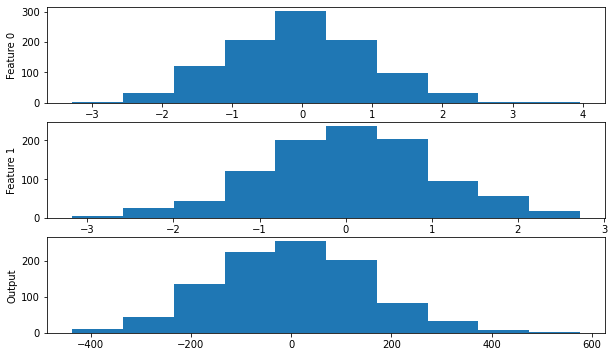

In [1]:
# regression predictive modeling problem
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

# generate regression dataset
# each input variable has a Gaussian distribution, as does the target variable. 
x, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

fig, ax = plt.subplots(3,1,figsize=(10,6))
# histograms of input variables

ax[0].hist(x[:, 0])
ax[0].set_ylabel("Feature 0")
ax[1].hist(x[:, 1])
ax[1].set_ylabel("Feature 1")

# histogram of target variable
ax[2].hist(y)
ax[2].set_ylabel("Output")
plt.show()

#### 2.1.2.1 Multilayer Perceptron With Unscaled Data

Train: nan, Test: nan


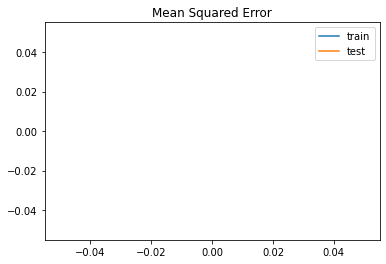

In [2]:
# mlp with unscaled data for the regression problem
from sklearn.datasets import make_regression
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# generate regression dataset
x, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

# split into train and test
n_train = 500
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', 
                kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

# compile model
model.compile(loss='mean_squared_error', 
              optimizer=SGD(lr=0.01, momentum=0.9))

# fit model
history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y), 
                    epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(train_x, train_y, verbose=0)
test_mse = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Running the example fits the model and calculates the mean squared error on the train and test sets. In this case, the model cannot learn the problem, resulting in predictions of **NaN values**. 

The model weights exploded during training given the very large errors and, in turn, error gradients calculated for weight updates.

This demonstrates that at the very least, **some data scaling is required for the target variable**. A line plot of training history is created but does not show anything as the model almost immediately results in a NaN mean squared error.

#### 2.1.2.2 Multilayer Perceptron With Scaled Output Variables

The example can be updated to scale the target variable. Reducing the scale of the target variable will, in turn, reduce the size of the gradient used to update the weights and result in a more stable model and training process. Given the Gaussian distribution of the target variable, a natural method for rescaling the variable would be to **standardize** it. This
requires estimating the mean and standard deviation of the variable and using these estimates to perform the rescaling. The best practice is to estimate the training dataset's mean and standard deviation and use these variables to scale the train and test dataset. This is to avoid
any data leakage during the model evaluation process. The scikit-learn transformers expect input data to be matrices of rows and columns. Therefore the 1D arrays for the target variable will have to be reshaped into 2D arrays prior to the transforms.

Rescaling the target variable means that estimating the model's performance and plotting the learning curves will calculate an MSE in squared units of the scaled variable rather than squared units of the original scale. This can make interpreting the error within the context
of the domain challenges. In practice, it may be helpful to estimate the performance of the model by first inverting the transform on the test dataset target variable and on the model predictions and estimating model performance using the root mean squared error on the unscaled data. **This is left as an exercise to the student**.

Train: 0.001, Test: 0.002


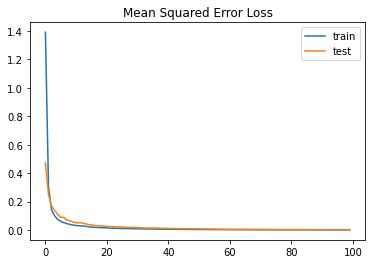

In [1]:
# mlp with scaled outputs on the regression problem
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# generate regression dataset
x, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

# split into train and test
n_train = 500
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# reshape 1d arrays to 2d arrays
train_y = train_y.reshape(len(train_y), 1)
test_y = test_y.reshape(len(train_y), 1)

# created scaler
scaler = StandardScaler()

# fit scaler on training dataset
scaler.fit(train_y)

# transform training dataset
train_y = scaler.transform(train_y)

# transform test dataset
test_y = scaler.transform(test_y)

# define model
model = Sequential()
model.add(Dense(25, input_dim=20, 
                activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

# compile model
model.compile(loss='mean_squared_error', 
              optimizer=SGD(lr=0.01, momentum=0.9))

# fit model
history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y),
                    epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(train_x, train_y, verbose=0)
test_mse = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
plt.title('Mean Squared Error Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

A line plot of the mean squared error on the train (blue) and test (orange) dataset over each training epoch is created. In this case, we can see that the model rapidly learns to map inputs to outputs for the regression problem effectively and achieves good performance on both
datasets throughout the run, neither overfitting nor underfitting the training dataset.

> It may be interesting to repeat this experiment and normalize the target variable instead
and compare results.

#### 2.1.2.3 Multilayer Perceptron With Scaled Input Variables

We have seen that data scaling can stabilize the training process when fitting a regression model with a widespread target variable. It is also possible to improve the stability and performance of the model by scaling the input variables. This section will design an experiment to compare the performance of different scaling methods for the input variables. The input variables also have a Gaussian data distribution, like the target variable. Therefore we would expect that standardizing the data would be the best approach. 

> This is just a heuristic, and it is always best to evaluate different scaling methods and discover what works best.

In [2]:
# compare scaling methods for mlp inputs on regression problem
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np

# prepare dataset with input and output scalers, can be none
def get_dataset(input_scaler, output_scaler):
  # generate dataset
  x, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

  # split into train and test
  n_train = 500
  train_x, test_x = x[:n_train, :], x[n_train:, :]
  train_y, test_y = y[:n_train], y[n_train:]

  # scale inputs
  if input_scaler is not None:
    # fit scaler
    input_scaler.fit(train_x)
    
    # transform training dataset
    train_x = input_scaler.transform(train_x)
    
    # transform test dataset
    test_x = input_scaler.transform(test_x)
  if output_scaler is not None:
    # reshape 1d arrays to 2d arrays
    train_y = train_y.reshape(len(train_y), 1)
    test_y = test_y.reshape(len(train_y), 1)
    
    # fit scaler on training dataset
    output_scaler.fit(train_y)

    # transform training dataset
    train_y = output_scaler.transform(train_y)
    
    # transform test dataset
    test_y = output_scaler.transform(test_y)
  return train_x, train_y, test_x, test_y

# fit and evaluate mse of model on test set
def evaluate_model(train_x, train_y, test_x, test_y):
	# define model
	model = Sequential()
	model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='linear'))
	
  # compile model
	model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))
	
  # fit model
	model.fit(train_x, train_y, epochs=100, verbose=0)
	
  # evaluate the model
	test_mse = model.evaluate(test_x, test_y, verbose=0)
	return test_mse

# evaluate model multiple times with given input and output scalers
def repeated_evaluation(input_scaler, output_scaler, n_repeats=30):
	# get dataset
	train_x, train_y, test_x, test_y = get_dataset(input_scaler, output_scaler)
	
  # repeated evaluation of model
	results = list()
	for _ in range(n_repeats):
		test_mse = evaluate_model(train_x, train_y, test_x, test_y)
		print('>%.3f' % test_mse)
		results.append(test_mse)
	return results

>0.006
>0.005
>0.004
>0.001
>0.004
>0.008
>0.015
>0.008
>0.010
>0.009
>0.006
>0.008
>0.003
>0.002
>0.001
>0.003
>0.002
>0.002
>0.011
>0.004
>0.005
>0.004
>0.007
>0.005
>0.010
>0.006
>0.003
>0.006
>0.007
>0.006
>0.000
>0.000
>0.000
>0.001
>0.001
>0.000
>0.000
>0.000
>0.000
>0.000
>0.000
>0.000
>0.000
>0.000
>0.001
>0.000
>0.000
>0.001
>0.000
>0.000
>0.001
>0.000
>0.000
>0.000
>0.001
>0.000
>0.000
>0.001
>0.000
>0.000
>0.008
>0.012
>0.005
>0.002
>0.008
>0.009
>0.004
>0.000
>0.007
>0.006
>0.008
>0.004
>0.006
>0.002
>0.007
>0.009
>0.012
>0.007
>0.006
>0.003
>0.001
>0.000
>0.009
>0.008
>0.008
>0.010
>0.003
>0.011
>0.003
>0.007
Unscaled: 0.006 (0.003)
Normalized: 0.000 (0.000)
Standardized: 0.006 (0.003)


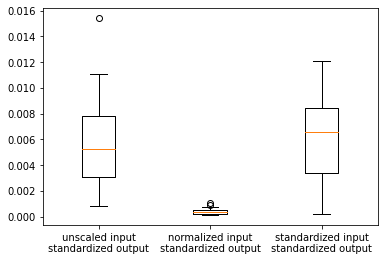

In [3]:
# unscaled inputs
results_unscaled_inputs = repeated_evaluation(None, StandardScaler())

# normalized inputs
results_normalized_inputs = repeated_evaluation(MinMaxScaler(), StandardScaler())

# standardized inputs
results_standardized_inputs = repeated_evaluation(StandardScaler(), StandardScaler())

# summarize results
print('Unscaled: %.3f (%.3f)' % (np.mean(results_unscaled_inputs), np.std(results_unscaled_inputs)))
print('Normalized: %.3f (%.3f)' % (np.mean(results_normalized_inputs), np.std(results_normalized_inputs)))
print('Standardized: %.3f (%.3f)' % (np.mean(results_standardized_inputs), np.std(results_standardized_inputs)))

# plot results
results = [results_unscaled_inputs, results_normalized_inputs, results_standardized_inputs]
labels = ['unscaled input\nstandardized output', 'normalized input\nstandardized output', 'standardized input\nstandardized output']
plt.boxplot(results, labels=labels)
plt.show()

A figure with three boxes and whisker plots is created summarizing the spread of error scores for each configuration. The plots show that there was little difference between the distributions of error scores for the unscaled and standardized input variables and that the normalized input
variables result in better performance and more stable or a tighter distribution of error scores.

These results highlight that it is important to actually experiment and confirm the results of data scaling methods rather than assuming that a given data preparation scheme will work best based on the observed distribution of the data.

## 2.2 Fix Vanishing Gradients with ReLU

In a neural network, **the activation function** is responsible for transforming the summed weighted input from the node into the activation of the node or output for that input. **The rectified linear activation function** is a piecewise linear function that will output the input directly if it is
positive; otherwise, it will output zero.  

>Relu has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

In this section, you will discover the rectified linear activation function for deep learning neural networks. After completing this section, you will know:

- The sigmoid and hyperbolic tangent activation functions cannot be used in networks with many layers due to the vanishing gradient problem.
- The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better.
- <font color="red">The rectified linear activation is the default activation when developing Multilayer Perceptrons and convolutional neural networks</font>.

### 2.2.1 Vanishing Gradients and ReLU

A neural network is comprised of layers of nodes and learns to map examples of inputs to outputs. For a given node, the inputs are multiplied by the weights in a node and summed together. This value is referred to as the summed activation of the node. The summed activation is then
transformed via an activation function and denotes the node's specific output or activation. The most straightforward activation function is referred to as the linear activation, where no transform is applied at all. A network comprised of only linear activation functions is very easy to train
but cannot learn complex mapping functions. Linear activation functions are still used in the output layer for networks that predict a quantity (e.g., regression problems).

> Nonlinear activation functions are preferred as they allow the nodes to learn more complex structures in the data. Traditionally, two widely used nonlinear activation functions are the **sigmoid** and **hyperbolic tangent** activation functions. 

The **sigmoid activation function**, also called the logistic function, is traditionally a very popular activation function for neural networks. The
input to the function is transformed into a value between 0.0 and 1.0. Inputs that are much larger than 1.0 are transformed to the value 1.0. Similarly, values much smaller than 0.0 are snapped to 0.0. The shape of the function for all possible inputs is an S-shape from zero up
through 0.5 to 1.0.  **For a long time, through the early 1990s, the default activation was used on neural networks**. 

The **hyperbolic tangent function**, or tanh for short, is a similar-shaped nonlinear activation function that outputs values between -1.0 and 1.0. In the later **1990s and through the 2000s, the tanh function was preferred over the sigmoid** activation function as models that used it were easier to train and often had a better predictive performance.


> A general problem with both the **sigmoid** and **tanh** functions is that they saturate.

This means that large values snap to 1.0 and small values snap to -1 or 0 for tanh and sigmoid, respectively. 

Further, the functions are only susceptible to changes around the mid-point of their input, such as 0.5 for sigmoid and 0.0 for tanh. The limited sensitivity and saturation
of the function happen regardless of whether the summed activation from the node provided as input contains useful information or not. **Once saturated, it becomes challenging for the learning algorithm to continue to adapt the weights to improve the model's performance.**

Finally, as hardware's capability increased through GPUs, very deep neural networks using **sigmoid** and **tanh** activation functions could not easily be trained. Layers deep in large networks using these nonlinear activation functions fail to receive useful gradient information.
Error is backpropagated through the network and used to update the weights. 

> The amount of error decreases dramatically with each additional layer through which it is propagated, given the derivative of the chosen activation function. This is called the **vanishing gradient** problem and prevents deep (multilayered) networks from learning effectively.

###  2.2.2 Rectified Linear Activation Function

In order to use stochastic gradient descent with backpropagation of errors to train deep neural networks, an activation function is needed that looks and acts like a linear function but is a nonlinear function allowing complex relationships in the data to be learned. 

The function must also provide more sensitivity to the activation sum input and avoid easy saturation. The solution had been bouncing around in the eldest for some time, although it was not highlighted until papers in 2009 and 2011 shone a light on it. **The solution is to use the rectified linear activation function, or ReLU for short**. A node or unit that implements this activation function is referred to as a rectified linear activation unit or ReLU for short.

Often, networks that use the rectifier function for the hidden layers are referred to as rectified networks. Adoption of ReLU may easily be considered one of the few milestones in the deep learning
revolution, e.g., the techniques that now permit the routine development of very deep neural networks.

The **rectified linear activation** function has rapidly become the default activation function when developing most types of neural networks. As such, it is crucial to take a moment to review
some of the benefits of the approach first highlighted by **Xavier Glorot** et al. in their milestone 2012 paper on using ReLU titled <font color="red"> Deep Sparse Rectifier Neural Networks</font>.

**Computational Simplicity**

> The rectifier function is trivial to implement, requiring a max() function. This is unlike the **tanh** and **sigmoid** activation functions that require the use of an exponential calculation.

**Representational Sparsity**

An important benefit of the rectifier function is that it is capable of outputting a genuine zero value. This is unlike the tanh and sigmoid activation functions that learn to approximate a zero
output, e.g., a value close to zero but not a real zero value. This means that negative inputs can output true zero values allowing the activation of hidden layers in neural networks to contain true zero values. This is called a sparse representation and is a desirable property in representational learning as it can accelerate learning and simplify the model. 


**The ReLU does have some limitations.**

> Key among the limitations of ReLU is when large weight updates can mean that the summed input to the activation function is always negative, regardless of the input to the network. This means that a node with this problem will forever output an activation value of 0.0. This is referred to as a **dying ReLU**.

### 2.2.3 ReLU Case Study

This section will demonstrate how to use ReLU to counter the vanishing gradient problem with a MLP on a simple classification problem. This example provides a template for exploring ReLU with your neural network for classification and regression problems.

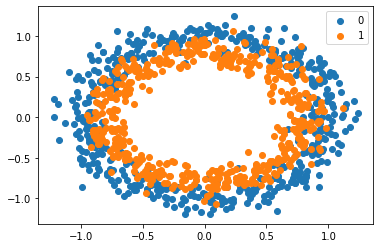

In [1]:
# scatter plot of the circles dataset with points colored by class
from sklearn.datasets import make_circles
import numpy as np
import matplotlib.pyplot as plt

# generate circles
x, y = make_circles(n_samples=1000, noise=0.1, random_state=1)

# select indices of points with each class label
for i in range(2):
	samples_ix = np.where(y == i)
	plt.scatter(x[samples_ix, 0], x[samples_ix, 1], label=str(i))
plt.legend()
plt.show()

#### 2.2.3.1 Multilayer Perceptron Model

Train: 0.822, Test: 0.846


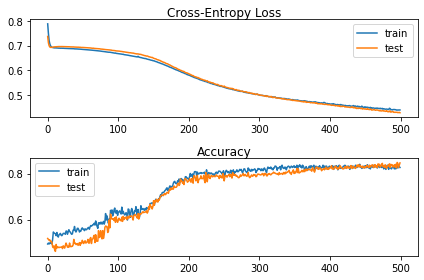

In [2]:
# mlp with tanh for the two circles classification problem
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import RandomUniform
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_circles(n_samples=1000, noise=0.1, random_state=1)

# scale input data to [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
x = scaler.fit_transform(x)

# split into train and test
n_train = 500
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()

# It was also good practice to initialize the network weights
# to small random values from a uniform distribution.
init = RandomUniform(minval=0, maxval=1)
model.add(Dense(5, input_dim=2, activation='tanh', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=500, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

A line plot of model loss and accuracy on the train and test sets are created, showing the overall 500 training epochs' performance change. The plots suggest, for this run, that the the performance begins to slow around epoch 200 at about 80% accuracy for both the train and
test sets.

Now that we have seen how to develop a classical MLP using the tanh activation function for the two circles problem, we can modify the model to have many more hidden layers.

#### 2.2.3.2 Deeper MLP Model

Traditionally, developing deep Multilayer Perceptron models was challenging. Deep models using the hyperbolic tangent activation function do not train quickly, and much of this poor performance is blamed on the vanishing gradient problem. We can attempt to investigate this
using the MLP model developed in the previous section. The number of hidden layers can be increased from 1 to 5; for example:

Train: 0.522, Test: 0.500


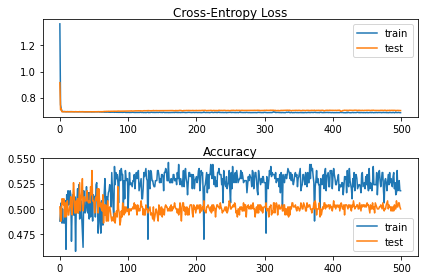

In [3]:
# deeper mlp with tanh for the two circles classification problem
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import RandomUniform
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_circles(n_samples=1000, noise=0.1, random_state=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x = scaler.fit_transform(x)

# split into train and test
n_train = 500
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
init = RandomUniform(minval=0, maxval=1)
model = Sequential()
model.add(Dense(5, input_dim=2, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y), epochs=500, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

#### 2.2.3.3 Deeper MLP Model with ReLU

The **rectified linear activation** function has supplanted the hyperbolic tangent activation function as the new preferred default when developing Multilayer Perceptron networks and other network types like CNNs. 

> This is because the activation function looks and acts like a linear
function, making it easier to train and less likely to saturate, but is, in fact, a nonlinear function, forcing negative inputs to the value 0. 

It is claimed as one possible approach to addressing the vanishing gradients problem when training deeper models. When using the rectified linear activation function (or ReLU for short), it is good practice to use the He weight initialization scheme. We can define the MLP with ve hidden layers using ReLU and He initialization, listed below.

Train: 0.840, Test: 0.844


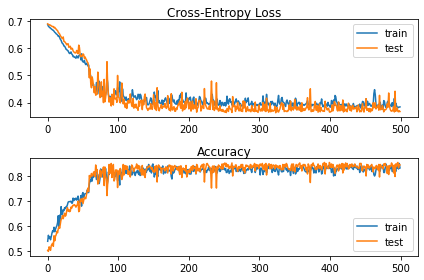

In [4]:
# deeper mlp with relu for the two circles classification problem (5 hidden layers)
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_circles(n_samples=1000, noise=0.1, random_state=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x = scaler.fit_transform(x)

# split into train and test
n_train = 500
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=500, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

A line plot of model accuracy on the train and test sets over training epochs is also created. The plot shows quite different dynamics to what we have seen so far. The model appears to rapidly learn the problem, converging on a solution in about 200 epochs.

Train: 0.820, Test: 0.828


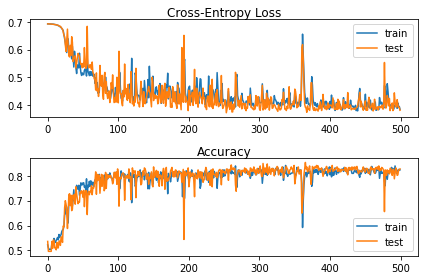

In [12]:
# deeper mlp with relu for the two circles classification problem (15 layers)
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_circles(n_samples=1000, noise=0.1, random_state=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x = scaler.fit_transform(x)

# split into train and test
n_train = 500
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y), epochs=500, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

The ReLU activation function has allowed us to fit a much more in-depth model for this simple problem, but this capability does not extend infinitely. For example, increasing the number of layers results in slower learning to a point at about 20 layers where the model is no
longer capable of learning the problem, at least with the chosen configuration. For example, below is a line plot of train and test accuracy of the same model with 15 hidden layers that shows that it is still capable of learning the problem (at least some of the time).

Train: 0.504, Test: 0.496


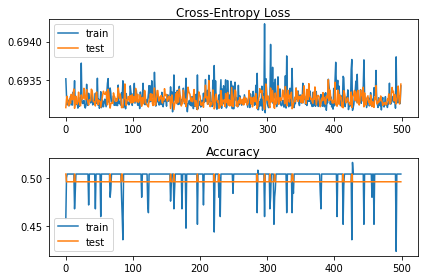

In [13]:
# deeper mlp with relu for the two circles classification problem (20 layers)
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_circles(n_samples=1000, noise=0.1, random_state=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
x = scaler.fit_transform(x)

# split into train and test
n_train = 500
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=500, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

## 2.3 Fix Exploding Gradients with Gradient Clipping

> Training a neural network can become unstable given the error function, learning rate, or even the target variable scale. 

Large updates to weights during training can cause a numerical overflow or underflow, often referred to as exploding gradients. The problem of exploding gradients is more familiar with recurrent neural networks, such as LSTMs, given the accumulation of gradients unrolled over hundreds of input time steps. 

A common and relatively easy solution to the **exploding gradients problem** is to change the derivative of the error before propagating it backward through the network and using it to update the weights.

Two approaches include rescaling the gradients given a chosen vector norm and clipping gradient values that exceed a preferred range. Together, these methods are referred to as **gradient clipping**.

This section will discover the exploding gradient problem and how to improve neural network training stability using gradient clipping.

### 2.3.1 Exploding Gradients and Clipping

Neural networks are trained using the stochastic gradient descent optimization algorithm. This requires estimating the loss on one or more training examples, then calculating the derivative of the loss, which is propagated backward through the network to update the weights. Weights are updated using a fraction of the backpropagated error controlled by the learning rate. 

> It is possible for the updates to the weights to be so large that the weights either overflow or underflow their numerical precision.

In practice, the **weights can take** on the value of a NaN (not a number) or Inf (infinity) when they **overflow** or **underflow**, and for practical purposes, the network will be useless from that point forward, forever predicting NaN values as signals ow through the invalid weights.


> The difficulty that arises is that when the parameter gradient is very large, a gradient descent parameter update could throw the parameters very far into a region where the objective function is larger, undoing much of the work that had been done to reach the current solution.


The **underflow** or **overflow of weights** is generally referred to as an instability of the network training process and is known by the name <font color="red">exploding gradients</font> as the unstable training process causes the network to fail to train in such a way that the model is essentially useless. A given
neural network, such as a Convolutional Neural Network or Multilayer Perceptron, can happen due to a poor configuration choice. Some examples include:

- Poor choice of learning rate that results in large weight updates.
- Poor choice of data preparation, allowing large differences in the target variable.
- Poor choice of the loss function, allowing the calculation of large error values.

Exploding gradients is also a problem in recurrent neural networks such as the Long Short-Term Memory network, given the accumulation of error gradients in the unrolled recurrent structure. Exploding gradients can be avoided in general by careful configuration of the network model, such as choice of the small learning rate, scaled target variables, and a standard loss function. Nevertheless, exploding gradients may still be an issue with recurrent networks with a large number of input time steps.


<font color="red">A common solution to exploding gradients</font> is to change the error derivative before propagating it backward through the network and using it to update the weights. By rescaling the error derivative, the updates to the weights will also be rescaled, dramatically decreasing the likelihood
of an overflow or underflow. There are two main methods for updating the error derivative; they are:

- Gradient Scaling.
- Gradient Clipping.

**Gradient scaling** involves normalizing the error gradient vector such that vector norm (magnitude) equals a defined value, such as 1.0.

On the other hand, **gradient clipping** involves forcing the gradient values (element-wise) to a specific minimum or maximum value if the gradient exceeded an expected range.  **Together, these methods are often simply referred to as gradient clipping**.

> When the traditional gradient descent algorithm proposes to make a very large step, the gradient clipping heuristic intervenes to reduce the step size to be small enough that it is less likely to go outside the region where the gradient indicates the direction of approximately steepest descent.

It is a method that **only addresses the numerical stability** of training deep neural network models and **does not offer any general improvement in performance**. The value for the gradient vector norm or preferred range can be configured by trial and error, by using common values
used in the literature or by first observing common vector norms or ranges via experimentation and then choosing a sensible value.

> It is common to use the same gradient clipping configuration for all layers in the network. Nevertheless, there are examples where a larger range of error gradients are permitted in the output layer compared to hidden layers.


#### 2.3.1.1 Gradient Norm Scaling

Gradient norm scaling involves changing the loss function derivatives to have a given vector norm when the L2 vector norm (sum of the squared values) of the gradient vector exceeds a threshold value. 

> For example, we could specify a norm of 1.0, meaning that if the vector norm
for a gradient exceeds 1.0, then the vector's values will be rescaled so that the norm of the vector equals 1.0. This can be used in Keras by specifying the **clipnorm** argument on the optimizer; for example:

```python
# configure sgd with gradient norm clipping
opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)
```

#### 2.3.1.2 Gradient Value Clipping

Gradient value clipping involves clipping the loss function's derivatives to have a given value if a gradient value is less than a negative threshold or more than the positive threshold.

> For example, we could specify a norm of 0.5, meaning that if a gradient value was less than -0.5, it is set to -0.5 and if it is more than 0.5, it will be set to 0.5. This can be used in Keras by specifying the **clipvalue** argument on the optimizer, for example:

```python
# configure sgd with gradient value clipping
opt = SGD(lr=0.01, momentum=0.9, clipvalue=0.5)
```

### 2.3.2 Gradient Clipping Case Study

This section will demonstrate how to use gradient clipping to counter the exploding gradients problem with a MLP on a simple classification problem. This example provides a template for exploring gradient clipping with your neural network for regression problems.

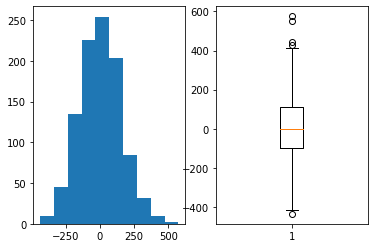

In [ ]:
# regression predictive modeling problem
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

# generate regression dataset
x, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

# histogram of target variable
plt.subplot(121)
plt.hist(y)

# boxplot of target variable
plt.subplot(122)
plt.boxplot(y)
plt.show()

#### 2.3.2.1 MLP With Exploding Gradients

We can develop a Multilayer Perceptron (MLP) model for the regression problem. A model will be demonstrated on the raw data without any scaling of the input or output variables. This is an excellent example to demonstrate exploding gradients as a model trained to predict the unscaled target variable will result in error gradients with values in the hundreds or even thousands, depending on the batch size used during training. Such large gradient values are likely to lead to unstable learning or an overflow of the weight values.

Train: nan, Test: nan


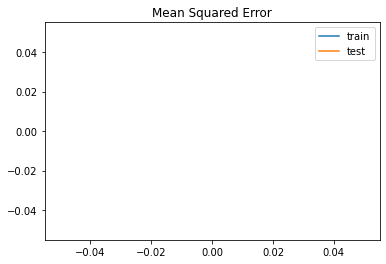

In [ ]:
# mlp with unscaled data for the regression problem
from sklearn.datasets import make_regression
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# generate regression dataset
x, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

# split into train and test
n_train = 500
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=20, 
                activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

# compile model
model.compile(loss='mean_squared_error', 
              optimizer=SGD(lr=0.01, momentum=0.9))

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(train_x, train_y, verbose=0)
test_mse = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

This demonstrates that some intervention is required concerning the target variable for the model to learn this problem. A line plot of training history is created but does not show anything as the model almost immediately results in a NaN mean squared error. 

> A traditional solution would be to rescale the target variable using either standardization or normalization, and this approach is recommended for MLPs. Nevertheless, an alternative that we will investigate in this case, it will be the use of gradient clipping.

#### 2.3.2.2 MLP With Gradient Norm Scaling

Train: 0.431, Test: 12.007


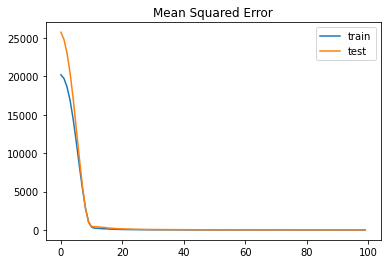

In [ ]:
# mlp with unscaled data for the regression problem with gradient norm scaling
from sklearn.datasets import make_regression
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# generate regression dataset
x, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

# split into train and test
n_train = 500
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=20, 
                activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

# compile model
opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt)

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(train_x, train_y, verbose=0)
test_mse = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

A line plot is also created showing the means squared error loss on the train and test datasets over training epochs. The plot shows how loss dropped from large values above 20,000 down to small values below 100 rapidly over 20 epochs.

There is nothing special about the vector norm value of 1.0, and other values could be
evaluated and the performance of the resulting model compared.

#### 2.3.2.3 MLP With Gradient Value Clipping

Another solution to the exploding gradient problem is to clip the gradient if it becomes too large or too small. We can update the training of the MLP to use gradient clipping by adding the clipvalue argument to the optimization algorithm configuration. For example, the code
below clips the gradient to the range $[-5\: to \:5]$.

Train: 17.943, Test: 25.309


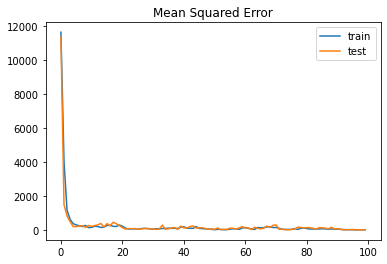

In [ ]:
# mlp with unscaled data for the regression problem with gradient clipping
from sklearn.datasets import make_regression
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# generate regression dataset
x, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

# split into train and test
n_train = 500
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=20, 
                activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

# compile model
opt = SGD(lr=0.01, momentum=0.9, clipvalue=5.0)
model.compile(loss='mean_squared_error', optimizer=opt)

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(train_x, train_y, verbose=0)
test_mse = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
plt.title('Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

A line plot is also created showing the means squared error loss on the train and test datasets over training epochs. The plot shows that the model learns the problem fast, achieving a sub-100
MSE loss within just a few training epochs.

A clipped range of $[-5, 5]$ was chosen arbitrarily; you can experiment with different sized ranges and compare performance of the speed of learning and final model performance.

# 3 Better Generalization

## 3.1 Fix overfitting with regularization

Training a deep neural network that can generalize well to new data is a challenging problem. A model with too little capacity cannot learn the problem, whereas a model with too much capacity can learn it too well and overfit the training dataset. Both cases result in a model that does not generalize well. 

> A modern approach to reducing generalization error is to use a larger model that may be required to use **regularization during training** that keeps the model's weights small. 

These techniques reduce overfitting and lead to faster optimization of the model and better overall performance. This section will discover the problem of overfitting when training neural networks and how it can be addressed with regularization methods. After reading this section, you will know:

- **Underfitting can quickly** be addressed by increasing the network's capacity, but overfitting requires the use of specialized techniques.
- Regularization methods like **weight decay** provide an easy way to **control overfitting** for sizeable neural network models.
- A modern recommendation for regularization is to use **early stopping** with **dropout** and a **weight constraint**.

### 3.1.1 Problem of model generalization and overfitting

A neural network's objective is to have a final model that performs well on the data that we used to train it (e.g., the training dataset) and the new data on which the model will be used to make predictions.

> The central challenge in machine learning is that we must perform well on new, previously unseen inputs - not just those on which our model was trained. The ability to perform well on previously unobserved inputs is called **generalization**.

We require that the model learn from known examples and generalize them to new examples in the future. We use methods like a train/test split or k-fold cross-validation to estimate the model's ability to generalize to new data. **learning and also generalizing to new cases is challenging**. 

Too little learning and the model will perform poorly on
the training dataset and on new data. **The model will underfit the problem**. 

Too much learning and the model will perform well on the training dataset and poorly on new data, the model will **overfit the problem**. In both cases, the model has not been generalized.



A model fit can be considered in the context of the <font color="red">bias-variance trade-off</font>. 

> An underfit model has high bias and low variance. 

Regardless of the specific samples in the training data, it cannot learn the problem. 
> An overfit model has low bias and high variance. 

The model learns the training data too well and performance varies widely with new unseen examples or even statistical noise added to examples in the training dataset.

**We can address underfitting by increasing the capacity of the model**. 

> Capacity refers to a model's ability to fit a variety of functions; more capacity means that a model can fit more types of functions for mapping inputs to outputs. 

Increasing the capacity of a model is
easily achieved by changing the structure of the model, such as adding more layers and/or more nodes to layers. Because an underfit model is so easily addressed, it is more common to have an
overfit model. 

**An overfit model is easily diagnosed by monitoring the model's performance during training** by evaluating both a training dataset and a holdout validation dataset. Graphing line plots of the performance of the model during training, called learning curves, will show a familiar pattern.

### 3.1.2 Reduce Overfitting by Constraining Complexity

There are two ways to approach an overfit model:

1. Reduce overfitting by training the network on more examples.
2. Reduce overfitting by changing the complexity of the network.

A benefit of very deep neural networks is that their performance improves as they are fed larger and larger datasets. A model with a near-infinite number of examples will eventually plateau in terms of the network's capacity is capable of learning. **A model can overfit a training dataset because it has sufficient capacity to do so**. Reducing the model's capacity reduces the likelihood of the model overfitting the training dataset to a point where it no longer overfits. The capacity of a neural network model, its complexity, is defined by its structure in terms of nodes and layers and the parameters in terms of its weights. Therefore, **we can reduce the complexity of a neural network to reduce overfitting in one of two
ways**:

1. Change network complexity by changing the network structure (number of weights).
2. Change network complexity by changing the network parameters (values of weights).

For example, the structure could be tuned via grid search until a suitable number of nodes and/or layers are found to reduce or remove overfitting for the problem. Alternately, the model could be overfitted and pruned by removing nodes until it achieves suitable performance on
a validation dataset. It is more common to instead constrain the model's complexity by **ensuring the parameters (weights) of the model remain small**. Small parameters suggest a less complex and, in turn, more stable model that is less sensitive to statistical fluctuations in the
input data.

> **Regularization** is any modification we make to a learning algorithm that is intended to **reduce its generalization error** but not its training error. Regularization is one of the central concerns of the field of machine learning, rivaled in its importance only by optimization.

### 3.1.3 Regularization Methods for Neural Networks

The simplest and perhaps **most common regularization method** is to **add a penalty to the loss function** in proportion to the weights' size in the model.


<font color="red">Weight Regularization:</font> Penalize the model during training **based on the magnitude of the weights**.

> This will encourage the model to map the inputs to the outputs of the training dataset so that the weights of the model are kept small. This approach is called weight regularization of **weight decay** and has proven very effective for decades for both more straightforward linear
models and neural networks.

Below is a list of five of the most common additional regularization methods.

- **Activity Regularization**: Penalize the model during training based on the magnitude
of the activations.
- **Weight Constraint**: Constrain the magnitude of weights to be within a range or below a limit.
- **Dropout**: Probabilistically remove inputs during training.
- **Noise**: Add statistical noise to inputs during training.
- **Early Stopping**: Monitor model performance on a validation set and stop training when performance degrades.

Some more specific recommendations include:

- **Classical**: use early stopping and weight decay (L2 weight regularization).
- **Alternate**: use early stopping and added noise with a weight constraint.
- **Modern**: use early stopping and dropout, in addition to a weight constraint.

## 3.2 Penalize Large Weights with Weight Regularization

Neural networks learn a set of weights that best map inputs to outputs. **A network with large network weights can sign an unstable network** where small changes in the input can lead to large changes in the output. This can signify that the network has overfitted the training dataset and will likely perform poorly when making predictions on new data. 

A solution to this problem is to update the learning algorithm to encourage the network to keep the weights small. This is called **weight regularization**, and it can be used as a general technique to reduce
the overfitting of the training dataset and improve the model's generalization. In this section, you will discover weight regularization as an approach to reduce overfitting for neural networks. After reading this tutorial, you will know:

- Large weights in a neural network signify a more complex network that has overfit the training data.
- Penalizing a network based on the size of the network weights during training can reduce overfitting.
- An L1 or L2 vector norm penalty can be added to the network's optimization to encourage smaller weights.



### 3.2.1 Weight Regularization


When fitting a neural network model, we must learn the network's weights (i.e., the model parameters) using stochastic gradient descent and the training dataset. The longer we train the network, the more specialized the weights will become to the training data, overfitting the training data. The weights will grow in size to handle the specifics of the examples seen
in the training data. **Large weights make the unstable network**. Although the weights will be specialized to the training dataset, minor variation or statistical noise on the expected inputs will result in large differences in the output.

Generally, **we refer to this model as having a large variance and a small bias**. That is, the model is sensitive to the specific examples, the statistical noise, in the training dataset. 

> A model with large weights is more complex than a model with smaller weights. 

It is a sign of a network that may be overly specialized to training data. In practice, we prefer to choose the simpler
models to solve a problem. **We prefer models with smaller weights**.

Another possible issue is that there may be many input variables, each with different relevance levels to the output variable. Sometimes we can use methods to help select input variables, but the interrelationships between variables are often not obvious. **Having small weights
or even zero weights for less relevant or irrelevant inputs to the network will allow the model to focus on learning**. This, too, will result in a simpler model.

### 3.2.2 Encourage Small Weights

The learning algorithm can be updated to encourage the network toward using small weights. One way to do this is to change the calculation of loss used in the network's optimization to consider the weights' size. Remember that we minimize a loss function when we train a neural network, such as the log loss in classification or mean squared error in regression. **We can add the current size of all weights in the network** or add a layer to this calculation in calculating the loss between the predicted and expected values in a batch. **This is called a penalty because we are penalizing the model proportional to the size of the weights in the model.**

> Many regularization approaches are based on limiting the capacity of models, such
as neural networks, linear regression, or logistic regression, by adding a [...] penalty to the objective function.

**Larger weights result in a larger penalty in the form of a larger loss score.** The optimization algorithm will then push the model to have smaller weights, i.e., weights no larger than needed to perform well on the training dataset. 

**Smaller weights are considered more regular or less specialized**, and as such, we refer to this penalty as **weight regularization**. When this approach of penalizing model coefficients is used in other machine learning models such as linear regression or logistic regression, it may be referred to as **shrinkage** because the penalty encourages the
coefficients shrink during the optimization process.

> The addition of a weight size penalty or weight regularization to a neural network has the effect of reducing generalization error and of allowing the model to pay less attention to less relevant input variables.

### 3.2.3 How to Penalize Large Weights

There are two parts to penalizing the model based on the size of the weights. The first is the calculation of the **size of the weights**, and the second is **the amount of attention** that the optimization process should pay to the penalty.

**Calculate Weight Size**

Neural network weights are real-values that can be positive or negative, as such, simply adding the weights is not sufficient. There are two main approaches used to calculate the size of the weights, they are:

- Calculate the sum of the absolute values of the weights, called the L1 norm (or $L^1$).
- Calculate the sum of the squared values of the weights, called the L2 norm (or $L^2$).

> L1 encourages weights to 0.0 if possible, resulting in more sparse weights (weights with more 0.0 values). 

> L2 offers more nuance, both penalizing larger weights more severely but resulting in less sparse weights. 

The use of L2 in linear and logistic regression is often referred to as **Ridge Regression**. This is useful when trying to develop an intuition for the penalty or examples of its usage.

**Control Impact of the Penalty**

The calculated size of the weights is added to the loss objective function when training the network. Rather than adding each weight to the penalty directly, they can be weighted using a new hyperparameter called alpha ($\alpha$) or sometimes lambda. 

This controls the amount of attention that the learning process should pay to the penalty. Put another way, the amount to penalize the model based on the size of the weights. 

> The $\alpha$ hyperparameter has a value between 0.0 (no penalty) and 1.0 (full penalty). This hyperparameter controls the model's amount of bias from 0.0, or low bias (high variance), to 1.0, or high bias (low variance).

- If the penalty is too strong, the model will underestimate the weights and underfit the problem. 
- If the penalty is too weak, the model will be allowed to overfit the training data. 

The vector norm of the weights is often calculated per-layer rather than across the entire network.

This allows more flexibility in the choice of the type of regularization used (e.g., L1 for inputs, L2 elsewhere) and flexibility in the $\alpha$ value, although **it is common to use the same $\alpha$
value on each layer by default.**

### 3.2.4 Weight Regularization Case Study

This section will **demonstrate how to use weight regularization** to reduce the overfitting of an MLP on a simple binary classification problem. This example provides a template for applying weight regularization to your neural network for classification and regression problems.

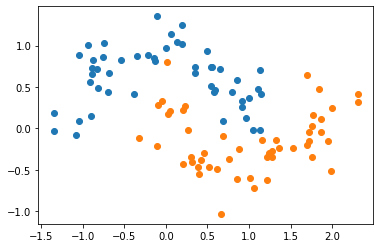

In [ ]:
# scatter plot of moons dataset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# scatter plot for each class value
for class_value in range(2):
	# select indices of points with the class label
	row_ix = np.where(y == class_value)
	# scatter plot for points with a different color
	plt.scatter(x[row_ix, 0], x[row_ix, 1])

# show plot
plt.show()

#### 3.2.4.1 Overfit Multilayer Perceptron Model

We can develop an MLP model to address this binary classification problem. The model will have one hidden layer with more nodes required to solve this problem, providing an opportunity to overfit. We will also train the model for longer than is necessary to ensure the model overfits. Before defining the model, we will split the dataset into train and test sets, using 30 examples to train the model and 70 to evaluate the t model's performance.

Train: 1.000, Test: 0.914


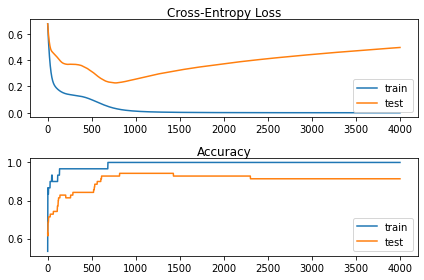

In [ ]:
# overfit mlp for the moons dataset
from sklearn.datasets import make_moons
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# split into train and test sets
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y), 
                    epochs=4000, verbose=0,batch_size=32)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

Line plots showing learning curves of cross-entropy loss and classification accuracy on the train and test sets for each training epoch are also created. **The learning curve for loss shows a clear overfitting pattern**, mirrored in the learning curve for the classification accuracy.

#### 3.2.4.2 MLP Model With Weight Regularization

Train: 1.000, Test: 0.943


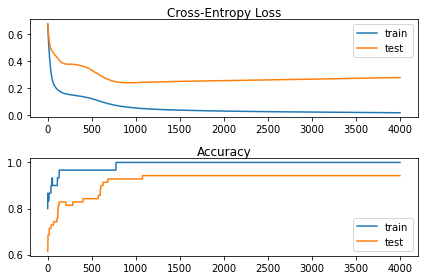

In [ ]:
# mlp with weight regularization for the moons dataset
from sklearn.datasets import make_moons
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# split into train and test sets
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu',
                kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

We would expect that it would have also changed the telltale learning curve for overfitting through weight regularization. Instead of improving the model's accuracy on the test set increasing and then decreasing again, we should see it continually rise during training. As expected, we see the learning curves for loss and accuracy on the test dataset plateau, indicating that the model has no longer overt the training dataset.

#### 3.2.4.3 Grid Search Regularization Hyperparameter

Param: 0.100000, Train: 0.967, Test: 0.829
Param: 0.010000, Train: 1.000, Test: 0.943
Param: 0.001000, Train: 1.000, Test: 0.943
Param: 0.000100, Train: 1.000, Test: 0.929
Param: 0.000010, Train: 1.000, Test: 0.929
Param: 0.000001, Train: 1.000, Test: 0.914


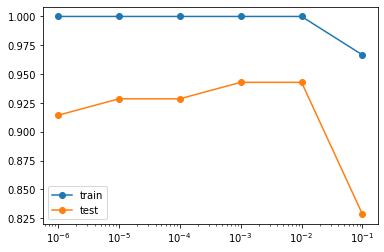

In [ ]:
# grid search regularization values for moons dataset
from sklearn.datasets import make_moons
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# grid search values
values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
all_train, all_test = list(), list()
for param in values:
	# define model
	model = Sequential()
	model.add(Dense(500, input_dim=2, activation='relu', kernel_regularizer=l2(param)))
	model.add(Dense(1, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	
  # fit model
	model.fit(train_x, train_y, epochs=4000, verbose=0)
 
	# evaluate the model
	_, train_acc = model.evaluate(train_x, train_y, verbose=0)
	_, test_acc = model.evaluate(test_x, test_y, verbose=0)
	print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
	all_train.append(train_acc)
	all_test.append(test_acc)
 
# plot train and test means
plt.semilogx(values, all_train, label='train', marker='o')
plt.semilogx(values, all_test, label='test', marker='o')
plt.legend()
plt.show()

A line plot of the results is also created, showing the increase in test accuracy with larger weight regularization parameter values, at least to a point. We can see that using the largest value of 0.1 results in a large drop in both train and test accuracy.

## 3.3 Force Small Weights with Weight Constraints

Weight regularization methods like weight decay introduce a penalty to the loss function when training a neural network to encourage the network to use small weights. Smaller weights in a neural network can result in a model that is more stable and less likely to overfit the training
dataset, in turn, have better performance when making a prediction on new data. 

> Unlike weight regularization, a weight constraint is a trigger that checks the size or magnitude of the weights and scales them so that they are all below a pre-defined threshold. 

The constraint forces weights to be small and can be used instead of weight decay and in conjunction with more aggressive network configurations, such as very large learning rates. **In this section, you
will discover the use of weight constraint regularization as an alternative to weight penalties to reduce overfitting in deep neural networks**. After reading this section, you will know:

- Weight penalties encourage but do not require neural networks to have small weights.
- Weight constraints, such as the L2 norm and maximum norm, can be used to force neural networks to have small weights during training.
- Weight constraints can improve generalization when used in conjunction with other regularization methods like a dropout.

### 3.3.1 Weight Constraints

In this section you will discover the problem with neural networks that have large weighs, a technique that you can use to force the development of models with small weights called **weight
constraints** and tips for using this technique in your own projects.

#### 3.3.1.1 Alternative to penalties for large weights

**Large weights in a neural network are a sign of overfitting**. A network with large weights has very likely learned the statistical noise in the training data. This results in a model that is unstable and very sensitive to changes to the input variables. 

> In turn, the overfit network
has poor performance when making predictions on new unseen data. 

A popular and effective technique to address the problem is to update the loss function that is optimized during training to take the size of the weights into account.

This is called a penalty, as the larger the weights of the network become, the more the network is penalized, resulting in larger loss and, in turn, larger updates. The effect is that the penalty encourages weights to be small or no larger than is required during the training process, in turn reducing overfitting. 

> A problem in using a penalty is that although it does encourage the network toward smaller weights, it does not force smaller weights. **A neural network trained with weight regularization penalty may still allow large weights, in some cases very large weights.**


#### 3.3.1.2 Force Small Weights

**An alternate solution to using a penalty for the size of network weights is to use a weight constraint**. A weight constraint is an update to the network that checks the size of the weights (e.g., their vector norm), and if the size exceeds a predefined limit, the weights are rescaled so
that their size is below the limit or between a range. You can think of a weight constraint as an if-then rule checking the size of the weights while the network is being trained and only coming into effect and making weights small when required. Note, for efficiency; it does not have to be
implemented as an if-then rule and often is not.

Unlike adding a penalty to the loss function, a weight constraint ensures the weights of the network are small instead of merely encouraging them to be small. It can be useful on those problems or with networks that resist other regularization methods, such as weight penalties. Weight constraints prove especially useful when you have configured your network to use alternative regularization methods to weight regularization and yet still desire the network to have small weights in order to reduce overfitting. 

> One often-cited example is the use of a **weight constraint regularization with dropout regularization**.

#### 3.3.1.3 How to use a weight constraint

A constraint is enforced on each node within a layer. All nodes within the layer use the same constraint, and often multiple hidden layers within the same network will use the same constraint.

Recall that when we talk about the vector norm in general, that this is the magnitude of the vector of weights in a node, and by default, is calculated as the L2 norm, e.g., the square root of the sum of the squared values in the vector. Some examples of constraints that could be used
include:

- Force the vector norm to be 1.0 (e.g., the unit norm).
- Limit the maximum size of the vector norm (e.g., the maximum norm).
- Limit the minimum and maximum size of the vector norm (e.g., the min-max norm).

The **maximum norm**, also called max-norm or maxnorm, is a popular constraint because it is less aggressive than other norms such as the unit norm, simply setting an upper bound.

When **using a limit or a range**, a hyperparameter must be specified. Given that weights are small, the hyperparameter, too, is often a small integer value, such as a value between 1 and 4.

If the **norm exceeds the specified range or limit**, the weights are rescaled or normalized such that their magnitude is below the specified parameter or within the specified range.

> The constraint can be applied after each update to the weights, e.g., at the end of each minibatch.

The Keras API supports weight constraints. The constraints are specified per-layer but applied and enforced per-node within the layer. Using a constraint generally involves setting the **kernel\_constraint** argument on the layer for the input weights and the **bias\_constraint** for the bias weights. **Generally, weight constraints are not used on the bias weights**. A suite of different vector norms can be used as constraints, provided as classes in the **keras.constraints** module. They are:

- **Maximum norm** (max\_norm), to force weights to have a magnitude at or below a given limit.
- **Non-negative norm** (non\_neg), to force weights to have a positive magnitude.
- **Unit norm** (unit\_norm), to force weights to have a magnitude of 1.0.
- **Min-Max norm** (min\_max\_norm), to force weights to have a magnitude between a range.

### 3.3.2 Weight Constraints Case Study

In this section, **we will demonstrate how to use weight constraints to reduce overfitting of an MLP on a simple binary classification problem**. This example provides a template for applying weight constraints to your own neural network for classification and regression problems.

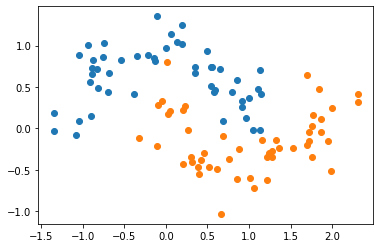

In [ ]:
# scatter plot of moons dataset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# scatter plot for each class value
for class_value in range(2):
	# select indices of points with the class label
	row_ix = np.where(y == class_value)
	# scatter plot for points with a different color
	plt.scatter(x[row_ix, 0], x[row_ix, 1])
# show plot
plt.show()

#### 3.3.2.1 Overfit multilayer perceptron

Train: 1.000, Test: 0.914


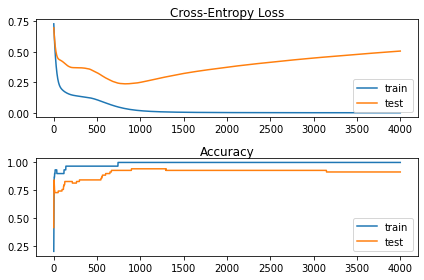

In [ ]:
# mlp overfit on the moons dataset
from sklearn.datasets import make_moons
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

Running the example reports the model performance on the train and test datasets. We can see that the model has better performance on the training dataset than the test dataset, one possible sign of overfitting.

#### 3.3.2.2 Overfit MLP With Weight Constraint

We can update the example to use a weight constraint. There are a few different weight
constraints to choose from. A good simple constraint for this model is to simply normalize the weights so that the norm is equal to 1.0. 

This constraint has the effect of forcing all incoming weights to be small. We can do this by using the unit norm in Keras. This constraint can be added to the first hidden layer as follows:

```python
model.add(Dense(500, input_dim=2, activation='relu', kernel_constraint=unit_norm()))
```

We can also achieve the same result by using the min max norm and setting the min and maximum to 1.0, for example:

```python
model.add(Dense(500, input_dim=2, activation='relu',kernel_constraint=min_max_norm(min_value=1.0, max_value=1.0)))
```

We cannot achieve the same result with the maximum norm constraint as it will allow norms at or below the specied limit; for example:

```python
model.add(Dense(500, input_dim=2, activation='relu',kernel_constraint=max_norm(1.0)))
```

Train: 1.000, Test: 0.943


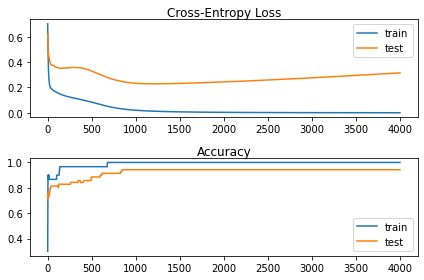

In [ ]:
# mlp overfit on the moons dataset with a unit norm constraint
from sklearn.datasets import make_moons
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.constraints import unit_norm
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu', kernel_constraint=unit_norm()))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

Reviewing the line plot of train and test loss and accuracy, we can see that it no longer appears that the model has overfit the training dataset. Model accuracy on both the train and test sets continues to improve to a plateau.

## 3.4 Decouple Layers with Dropout

Deep learning neural networks are likely to quickly overfit a training dataset with few examples. Ensembles of neural networks with different model configurations are known to reduce overfitting but require the additional computational expense of training and maintaining multiple models. 

> A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during training. 

This is called **dropout** and **offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and
generalization error in deep neural networks of all kinds**. 

In this section, you will discover the use of dropout regularization for reducing overfitting and improving the generalization of deep neural networks. After reading this section, you will know:

- Large weights in a neural network are a sign of a more complex network that has overfitted the training data.
- Probabilistically dropping out nodes in the network is a simple and effective regularization method.
- A large network with more training epochs and the use of a weight constraint is suggested when using dropout.

### 3.4.1 Dropout

In this section you will discover that you can simulate the development of a large ensemble of neural network models in a single model called **dropout**, how you can use it to reduce overfitting, and tips for using this technique on your own projects.

#### 3.4.1.1 Problem With Overfitting

Large neural nets trained on relatively small datasets can overfit the training data. This has the effect of the model learning the statistical noise in the training data, which results in poor performance when the model is evaluated on new data, e.g., a test dataset. Generalization error
increases due to overfitting. One approach to reducing overfitting is to fit all possible different neural networks on the same dataset and to average the predictions from each model. This is not feasible in practice, and can be approximated using a small collection of different models,
called an ensemble.

> A problem even with the ensemble approximation is that it requires multiple models to be fit and stored, which can be a challenge if the models are large, requiring days or weeks to train and tune.

#### 3.4.1.2 Randomly Drop Nodes

**Dropout is a regularization method** that approximates training a large number of neural networks with different architectures in parallel. 

> During training, some number of node outputs are randomly ignored or dropped out. 

This has the effect of making the layer look-like and be
treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different view of the configured layer.

> **Dropout has the effect of making the training process noisy**, forcing nodes within a layer to probabilistically take on more or less responsible for the inputs.

This conceptualization suggests that perhaps dropout breaks-up situations where network layers co-adapt to correct mistakes from prior layers, in turn making the model more robust.

Because the outputs of a layer under dropout are randomly subsampled, it has the effect of reducing the capacity or thinning the network during training. As such, a wider network, e.g., more nodes, may be required when using dropout.

#### 3.4.1.3 How to Dropout

Dropout is implemented per-layer in a neural network. It can be used with most types of layers, such as dense fully connected layers, convolutional layers, and recurrent layers such as the long
short-term memory network layer. 

> Dropout may be implemented on any or all hidden layers in the network as well as the visible or input layer. **It is not used on the output layer**.


**A new hyperparameter** is introduced that specifies the probability at which outputs of the layer are dropped out, or inversely, the probability at which outputs of the layer are retained.

The interpretation is an implementation detail that can differ from paper to code library. 

> A common value is a probability of 0.5 for retaining the output of each node in a hidden layer and a value close to 1.0, such as 0.8, for retaining inputs from the visible layer.

**Dropout is not used after training when making a prediction with the fit network**. The weights of the network will be larger than normal because of dropout. Therefore, before finnalizing
the network, the weights are firrst scaled by the chosen dropout rate. The network can then be used as per normal to make predictions.

The rescaling of the weights can be performed at training time instead, after each weight update at the end of the minibatch. 

> This is sometimes called **inverse dropout** and does not
require any modification of weights during training. Both the Keras and PyTorch deep learning libraries implement dropout in this way.

**Dropout works well in practice**, perhaps replacing the need for weight regularization (e.g. weight decay) and activation regularization (e.g. representation sparsity).

### 3.4.2 Dropout Case Study

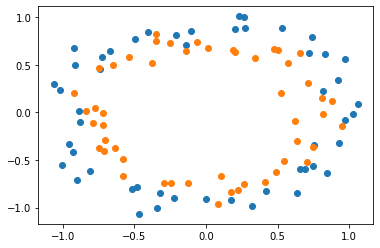

In [ ]:
# scatter plot of circles dataset
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np

# generate 2d classification dataset
x, y = make_circles(n_samples=100, noise=0.1, random_state=1)

# scatter plot for each class value
for class_value in range(2):
	# select indices of points with the class label
	row_ix = np.where(y == class_value)
 
	# scatter plot for points with a different color
	plt.scatter(x[row_ix, 0], x[row_ix, 1])
# show plot
plt.show()

#### 3.4.2.1 Overfit multilayer perceptron

Train: 1.000, Test: 0.757


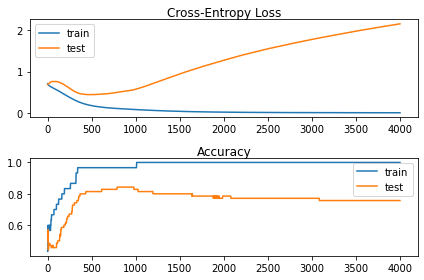

In [ ]:
# mlp overfit on the two circles dataset
from sklearn.datasets import make_circles
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_circles(n_samples=100, noise=0.1, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

#### 3.4.2.2 MLP with dropout regularization

We can update the example to use dropout regularization. We can do this by simply inserting a new Dropout layer between the hidden layer and the output layer. In this case, we will specify a dropout rate (probability of setting outputs from the hidden layer to zero) to 40% or 0.4.

```python
# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

Train: 0.967, Test: 0.800


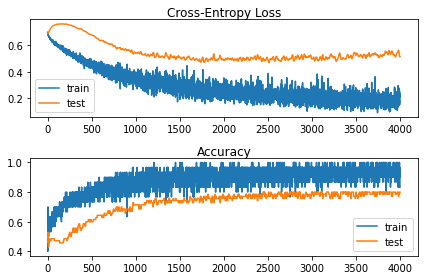

In [ ]:
# mlp with dropout on the two circles dataset
from sklearn.datasets import make_circles
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_circles(n_samples=100, noise=0.1, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

In this specific case, we can see that dropout resulted in a slight drop in accuracy on the training dataset, down from 100% to 96%, and a lift in accuracy on the test set, up from 75% to 80%.

Reviewing the line plot of train and test accuracy during training, we can see that it no longer appears that the model has overfit the training dataset. Model accuracy on both the train and test sets continues to increase to a plateau, albeit with a lot of noise given the use of dropout during training.

## 3.5 Promote Robustness with Noise

Training a neural network with a small dataset can cause the network to memorize all training examples, in turn leading to poor performance on a holdout dataset. Small datasets may also represent a harder mapping problem for neural networks to learn, given the patchy or sparse
a sampling of points in the high-dimensional input space. 

> One approach to making the input space smoother and easier to learn is to add noise to inputs during training. 

In this section, **you will discover that adding noise to a neural network during training can improve the robustness of the network, resulting in better generalization and faster learning**. 

After reading this section, you will know:

- Small datasets can make learning challenging for neural nets, and the examples can be memorized.
- Adding noise during training can make the training process more robust and reduce generalization error.
- Noise is traditionally added to the inputs but can also be added to weights, gradients, and even activation functions.

### 3.5.1 Noise Regularization

In this section, you will discover the brittleness of large network weights and how the addition of statistical noise can provide a regularizing effect, as well as tips to help when adding noise to your own neural network models.

#### 3.5.1.1 Add Random Noise During Training

One approach to improving generalization error and to improving the structure of the mapping problem is to add random noise.

At first, this sounds like a recipe for making learning more challenging. It is a counter-intuitive suggestion to improving performance because one would expect noise to degrade performance of the model during training.

> Heuristically, we might expect that the noise will 'smear out' each data point and make it dicult for the network to fit individual data points precisely, and hence will reduce overfitting. In practice, it has been demonstrated that training with noise can indeed lead to improvements in network generalization.

The addition of noise during the training of a neural network model has a regularization effect and, in turn, improves the robustness of the model. It has been shown to have a similar impact on the loss function as the addition of a penalty term, as in the case of weight regularization
methods.

In effect, adding noise expands the size of the training dataset. Each time a training sample is exposed to the model, random noise is added to the input variables making them different every time it is exposed to the model. In this way, adding noise to input samples is a simple
form of **data augmentation**.

> Injecting noise in the input to a neural network can also be seen as a form of data
augmentation.

**Adding noise means that the network is less able to memorize training samples because they are changing all of the time**, resulting in smaller network weights and a more robust network that has lower generalization error. The noise means that it is as though new samples are being drawn from the domain in the vicinity of known samples, smoothing the structure of the input space. This smoothing may mean that the mapping function is easier for the network to learn, resulting in better and faster learning.

#### 3.5.1.2 How and Where to Add Noise

The most common type of **noise used during training** is the addition of **Gaussian noise** to input variables. Gaussian noise, or white noise, has a **mean of zero and a standard deviation of one** and can be generated as needed using a pseudorandom number generator. The addition of Gaussian noise to the inputs to a neural network was traditionally referred to as **jitter or random jitter** after the use of the term in signal processing to refer to the uncorrelated random noise
in electrical circuits. 

> The amount of noise added (e.g. the spread or standard deviation) is a configurable hyperparameter. 

**Too little noise has no effect, whereas too much noise makes the
mapping function too challenging to learn.**

The **standard deviation of the random noise** controls the amount of spread and can be adjusted based on the scale of each input variable. It can be easier to configure if the scale of the input variables has first been normalized. <font color='red'>Noise is only added during training</font>. No noise is added during the evaluation of the model or when the model is used to make predictions on new data.

Although additional noise to the inputs is the most common and widely studied approach, random noise can be added to other network parts during training. Some examples include:

- **Add noise to activations**, i.e., the outputs of each layer.
- **Add noise to weights**, i.e., an alternative to the inputs.
- **Add noise to the gradients**, i.e., the direction to update weights.
- **Add noise to the outputs**, i.e., the labels or target variables.

The **addition of noise** to the **layer activations** allows noise to be used at any point in the network. This can be **beneficial for very deep networks**. Noise can be added to the layer outputs themselves, but this is more likely achieved via a noisy activation function. 

The **addition of noise** to **weights** allows the approach to be used throughout the network consistently instead of adding noise to inputs and layer activations. This is **particularly useful in recurrent neural networks**.

The **addition of noise** to **gradients** focuses more on **improving the optimization process's robustness** rather than the structure of the input domain. The amount of noise can start high at the beginning of training and decrease over time, much like a decaying learning rate.
This approach has proven to be an effective method for very deep networks and a variety of different network types.

> Adding noise to the activations, weights, or gradients all provides a more generic approach to adding noise invariant to the types of input variables provided to the model. 

If the problem domain is believed or expected to have mislabeled examples, then the addition of noise
to the class label can improve the model's robustness to this type of error. Although, it can be easy to derail the learning process. Adding noise to a continuous target variable in the case of regression or time series forecasting is much like the addition of noise to the input variables and
maybe a better use case.

> Noise can be added to training regardless of the type of problem that is being addressed. It is appropriate to try adding noise to both classification and regression type problems. The type of noise can be specialized to the types of data used as input to the model, for example,
**two-dimensional noise** in the case of **images** and **signal noise** in the case of **audio data**.

<font color='red'>Noise is only added during the training of your model</font>. Be sure that any source of noise is not added during the evaluation of your model, or when your model is used to make predictions on new data.

Keras supports the addition of noise to models via the **GaussianNoise layer**. This is a layer that will add noise to inputs of a given shape. The noise has a mean of zero and requires that a standard deviation of the noise be specifed as a hyperparameter. For example:

```python
# import noise layer
from keras.layers import GaussianNoise
# define noise layer
layer = GaussianNoise(0.1)
```

The **GaussianNoise layer** can be used in a few different ways with a neural network model. Firstly, it can be used as an input layer to add noise to input variables directly. This is the traditional use of noise as a regularization method in neural networks. Below is an example of
defining a **GaussianNoise layer** as an input layer for a model that takes 2 input variables.

```python
...
model.add(GaussianNoise(0.01, input_shape=(2,)))
...
```

**Noise** can also be added **between hidden layers** in the model. Given the flexibility of Keras, the noise can be added before or after the use of the activation function. It may make more sense
to add it before the activation; nevertheless, both options are possible. Below is an example of a **GaussianNoise layer** that adds noise to the linear output of a Dense layer before a rectified
linear activation function, perhaps a more appropriate use of noise between hidden layers.

```python
...
model.add(Dense(32))
model.add(GaussianNoise(0.1))
model.add(Activation('relu'))
model.add(Dense(32))
...
```

Noise can also be added after the activation function, much like using a noisy activation function. One downside of this usage is that the resulting values may be out-of-range from what the activation function may normally provide. For example, a value with added noise may be less than zero, whereas the relu activation function will only ever output values 0 or larger.

```python
...
model.add(Dense(32, activation='reu'))
model.add(GaussianNoise(0.1))
model.add(Dense(32))
...
```

### 3.5.2 Noise Regularization Case Study

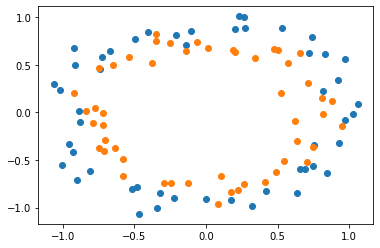

In [ ]:
# scatter plot of circles dataset
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np

# generate 2d classification dataset
x, y = make_circles(n_samples=100, noise=0.1, random_state=1)

# scatter plot for each class value
for class_value in range(2):
	# select indices of points with the class label
	row_ix = np.where(y == class_value)
	# scatter plot for points with a different color
	plt.scatter(x[row_ix, 0], x[row_ix, 1])
# show plot
plt.show()

#### 3.5.2.1 Overfit multilayer perceptron

Train: 1.000, Test: 0.771


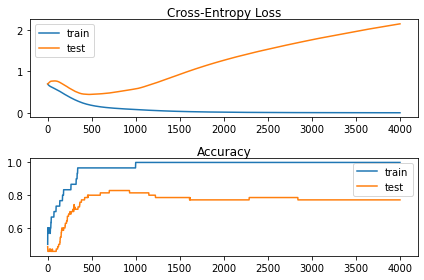

In [ ]:
# mlp overfit on the two circles dataset
from sklearn.datasets import make_circles
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_circles(n_samples=100, noise=0.1, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[: n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

#### 3.5.2.2 MLP with input layer noise

The dataset is defined by points that have a controlled amount of statistical noise. Nevertheless, because the dataset is small, we may wish to add further noise to the input values. This will have the effect of creating more samples or resampling the domain, making the structure of the input space articially smoother. This may make the problem easier to learn and improve
generalization performance. We can add a **GaussianNoise layer** as the **input layer**. The amount of noise must be small. Given that the input values are within the range $[0, 1]$, we will add Gaussian noise with a mean of 0.0 and a standard deviation of 0.1, chosen arbitrarily.

Train: 0.900, Test: 0.671


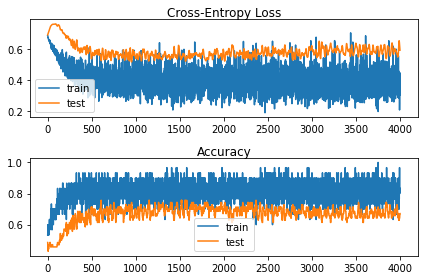

In [ ]:
# mlp overfit on the two circles dataset with input noise
from sklearn.datasets import make_circles
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GaussianNoise
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_circles(n_samples=100, noise=0.1, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(GaussianNoise(0.1, input_shape=(2,)))
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

We clearly see the impact of the added noise on the evaluation of the model during training as graphed on the line plot. The noise causes the accuracy of the model to jump around during training, possibly due to the noise introducing points that conflict with true points from the training dataset. Perhaps a lower input noise standard deviation would be more appropriate.

The model still shows a pattern of being overfit, with a rise and then fall in test accuracy over training epochs.

#### 3.5.3.3 MLP with hidden layer noise


Train: 0.967, Test: 0.786


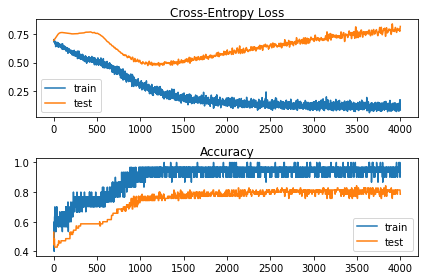

In [ ]:
# mlp overfit on the two circles dataset with hidden layer noise
from sklearn.datasets import make_circles
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GaussianNoise
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_circles(n_samples=100, noise=0.1, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2))
model.add(GaussianNoise(0.1))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

We can also see from the line plot of accuracy over training epochs that the model no longer appears to show the properties of being overfit with regard to classification accuracy. The learning curves for loss do still show a pattern of being overfit.


> We can also experiment and add the noise after the outputs of the rst hidden layer pass through the activation function.

Train: 1.000, Test: 0.786


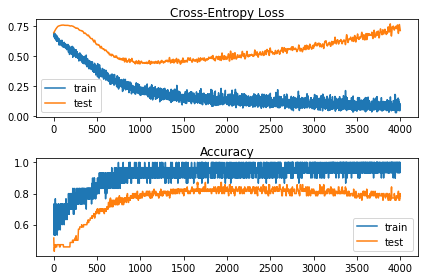

In [ ]:
# mlp overfit on the two circles dataset with hidden layer noise
from sklearn.datasets import make_circles
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GaussianNoise
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_circles(n_samples=100, noise=0.1, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2,activation='relu'))
model.add(GaussianNoise(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

Surprisingly, we see little difference in the performance of the model, perhaps a small lift in performance.

Again, we can see from the line plot of accuracy over training epochs that the model no longer shows sign of overfitting.

## 3.6 Halt Training at the Right Time with Early Stopping

A major challenge in training neural networks is how long to train them. Too little training will mean that the model will underfit the train and the test sets. Too much training will mean that the model will overfit the training dataset and have poor performance on the test set. A compromise is to train on the training dataset but to stop training at the point when performance on a validation dataset starts to degrade. 

This simple, effective, and widely used approach to training neural networks is called **early stopping**. This section will discover
that stopping the training of a neural network early before it has overfited the training dataset can reduce overfitting and improve the generalization of deep neural networks. After reading this section, you will know:

- The challenge of training a neural network long enough to learn the mapping, but not so long that it overfits the training data.
- Model performance on a holdout validation dataset can be monitored during training and training stopped when generalization error starts to increase.
- The use of early stopping requires the selection of a performance measure to monitor, a trigger to stop training, and a selection of the model weights to use.

### 3.6.1 Early Stopping

In this section discover the problem of training a model for too long and the regularizing effect that halting the training process at the right time can have, as well as tips for using early
stopping in your own projects.

#### 3.6.1.1 The problem of training just enough

Training neural networks is challenging. 
> When training a large network, there will be a point during training when the model will stop generalizing and start learning the training dataset's statistical noise. 

This overtting of the training dataset will increase generalization error, making the model less useful in making predictions on new data. 

**The challenge is to train the network long enough to learn the mapping** from inputs to outputs, **but not training the model so long that it overfits** the training data.

One approach to solving this problem is to treat the **number of training epochs as a hyperparameter**, train the model multiple times with different values, and then select the number of epochs that result in the train's best performance or a holdout test dataset. The downside of this approach is that it requires multiple models to be trained and discarded. 
This can be computationally ineffcient and time-consuming, especially for large models trained on large datasets over days or weeks.

#### 3.6.1.2 Stop Training When Generalization Error Increases

An alternative approach is to train the model once for a large number of training epochs. During training, the model is evaluated on a holdout validation dataset after each epoch. If the performance of the model on the validation dataset starts to degrade (e.g. loss begins to
increase or accuracy begins to decrease), then the training process is stopped.

When training is stopped, the model is then used and is known to have good generalization performance. This procedure is called **early stopping** and is perhaps one of the **oldest and most widely used forms of neural network regularization**.

If regularization methods like weight decay that update the loss function to encourage less complex models are considered explicit regularization, then early stopping may be thought of as a type of implicit regularization, much like using a smaller network that has less capacity.

#### 3.6.1.3 How to stop training early

**Early stopping** requires that you configure your network to be under constrained, **meaning that it has more capacity than is required for the problem**. 

When training the network, a larger
number of training epochs is used than may normally be required, to give the network plenty of opportunity to fit, then begin to overfit the training dataset. There are three elements to using early stopping; they are:

- Monitoring model performance.
- Trigger to stop training.
- The choice of model to use.

**Monitoring performance**

The performance of the model must be monitored during training. This requires choosing a dataset used to evaluate the model and a metric used to evaluate the model. It is common to split the training dataset and use a subset, such as 30%, as a validation dataset used to monitor the model's performance during training. This validation set is not used to train the model. It is also common to use the loss on a validation dataset as the metric to monitor, although you may also use prediction error in the case of regression, or accuracy in 
classication.

The loss of the model on the training dataset will also be available as part of the training procedure, and additional metrics may also be calculated and monitored on the training dataset. Performance of the model is evaluated on the validation set at the end of each epoch, which
adds computational cost during training. This can be reduced by evaluating the model less frequently, such as every 2, 5, or 10 training epochs.

**Early Stopping Trigger**

Once a scheme for evaluating the model is selected, a trigger for stopping the training process must be chosen. The trigger will use a monitored performance metric to decide when to stop training. This is often the performance of the model on the holdout dataset, such as the loss. 

In the simplest case, training is stopped as soon as the performance on the validation dataset decreases compared to the performance on the validation dataset at the prior training epoch (e.g. an increase in loss). More elaborate triggers may be required in practice. This is because the training of a neural network is stochastic and can be noisy. Plotted on a graph, a model's performance on a validation dataset may go up and down many times. This means that the first sign of overtting may not be a good place to stop training.

**Some more elaborate triggers may include**:

- No change in metric over a given number of epochs.
- An absolute change in a metric.
- A decrease in performance observed over a given number of epochs.
- Average change in metric over a given number of epochs.

Some delay or patience in stopping is almost always a good idea.


**Model Choice**

When training is halted, the model is known to have a slightly worse generalization error than a prior epoch model. As such, some consideration may need to be given as to exactly which model is saved. 

Specifically, the training epoch from which weights in the model
are saved to file. This will depend on the trigger chosen to stop the training process. For example:

- If the trigger is a simple decrease in performance from one epoch to the next, then the weights for the model at the prior epoch will be preferred. 
- If the trigger is required to observe a decrease in performance over a fixed number of epochs, then the model at the beginning of the trigger period will be preferred. 

> **Perhaps a simple approach** is to ,<font color='red'>always save the model weights if the model's performance on a holdout dataset is better than at the previous epoch</font>. That way, you will always have the model with the best performance on the holdout set.

### 3.6.2 Early Stopping Case Study

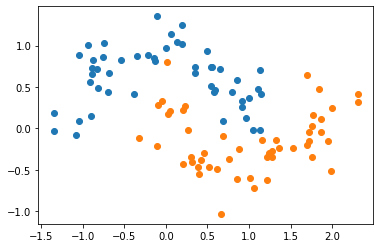

In [ ]:
# scatter plot of moons dataset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)
# scatter plot for each class value

for class_value in range(2):
	# select indices of points with the class label
	row_ix = np.where(y == class_value)
	# scatter plot for points with a different color
	plt.scatter(x[row_ix, 0], x[row_ix, 1])
# show plot
plt.show()

#### 3.6.2.1 Overfit Multilayer Perceptron

Train: 1.000, Test: 0.914


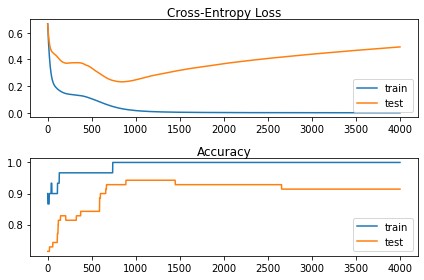

In [ ]:
# mlp overfit on the moons dataset
from sklearn.datasets import make_moons
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

#### 3.6.2.2 Overfit MLP with early stopping

Epoch 00220: early stopping
Train: 0.967, Test: 0.814


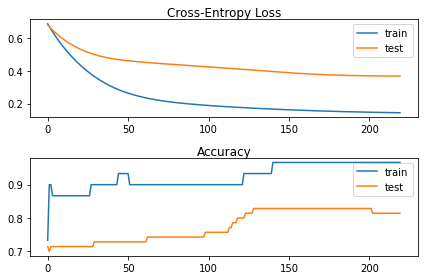

In [ ]:
# mlp overfit on the moons dataset with simple early stopping
from sklearn.datasets import make_moons
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0, callbacks=[es])

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

We can also see that the callback stopped training at epoch 239. This is too early as we would expect an early stop to be around epoch 800. This is also highlighted by the classification accuracy on both the train and test sets, which is worse than no early stopping.

Reviewing the line plot of train and test loss, we can indeed see that training was stopped at the point when validation loss began to plateau for the first time.

We can improve the trigger for early stopping by waiting a while before stopping. This can be achieved by setting the **patience** argument. In this case, we will wait 200 epochs before training is stopped. Specifically, this means that we will allow training to continue for up to an
additional 200 epochs after the point that validation loss started to degrade, giving the training process an opportunity to get across  at spots or find some additional improvement.

Epoch 00987: early stopping
Train: 1.000, Test: 0.943


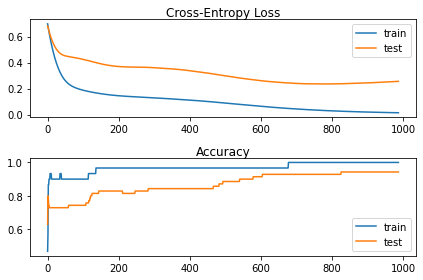

In [ ]:
# mlp overfit on the moons dataset with patient early stopping
from sklearn.datasets import make_moons
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0, callbacks=[es])

# evaluate the model
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

Running the example, we can see that training was stopped much later, in this case just before epoch 1,000. We can also see that the performance on the test dataset is better than not using any early
stopping. Reviewing the line plot of loss during training, we can see that the patience allowed the training to progress past some small at and bad spots.

We can also see that test loss started to increase again in the last approximately 100 epochs. This means that although the model's performance has improved, we may not have the
best performing or most stable model at the end of training. We can address this by using a **ModelChecckpoint callback**. In this case, we are interested in saving the model with the best accuracy on the test dataset. We could also seek the model with the best loss on the test
dataset, but this may or may not correspond to the best accuracy model.

This highlights an important concept in model selection. The notion of the best model during training may conflict when evaluated using different performance measures. 

> Try to choose models based on the metric by which they will be evaluated and presented in the domain. 

In a balanced binary classication problem, this will most likely be classification accuracy. Therefore, we will use accuracy on the validation in the **ModelCheckpoint callback** to save the best model observed during training.

```python
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1,
save_best_only=True)
```

In [ ]:
# mlp overfit on the moons dataset with patient early stopping and model checkpointing
from sklearn.datasets import make_moons
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# generate 2d classification dataset
x, y = make_moons(n_samples=100, noise=0.2, random_state=1)

# split into train and test
n_train = 30
train_x, test_x = x[:n_train, :], x[n_train:, :]
train_y, test_y = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                     mode='max', verbose=1, save_best_only=True)

# fit model
history = model.fit(train_x, train_y,
                    validation_data=(test_x, test_y),
                    epochs=4000, verbose=0, callbacks=[es, mc])

# load the saved model
saved_model = load_model('best_model.h5')

# evaluate the model
_, train_acc = saved_model.evaluate(train_x, train_y, verbose=0)
_, test_acc = saved_model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))



Epoch 00001: val_accuracy improved from -inf to 0.62857, saving model to best_model.h5

Epoch 00002: val_accuracy improved from 0.62857 to 0.85714, saving model to best_model.h5

Epoch 00003: val_accuracy did not improve from 0.85714

Epoch 00004: val_accuracy did not improve from 0.85714

Epoch 00005: val_accuracy did not improve from 0.85714

Epoch 00006: val_accuracy did not improve from 0.85714

Epoch 00007: val_accuracy did not improve from 0.85714

Epoch 00008: val_accuracy did not improve from 0.85714

Epoch 00009: val_accuracy did not improve from 0.85714

Epoch 00010: val_accuracy did not improve from 0.85714

Epoch 00011: val_accuracy did not improve from 0.85714

Epoch 00012: val_accuracy did not improve from 0.85714

Epoch 00013: val_accuracy did not improve from 0.85714

Epoch 00014: val_accuracy did not improve from 0.85714

Epoch 00015: val_accuracy did not improve from 0.85714

Epoch 00016: val_accuracy did not improve from 0.85714

Epoch 00017: val_accuracy did not im

Running the example, we can see the verbose output from the ModelCheckpoint callback
for both when a new best model is saved and from when no improvement was observed. We can see that the best model was observed at epoch 956 during this run.

Again, we can see that early stopping continued patiently until after epoch 1,105. Note that
epoch 956 + a patience of 200 is not epoch 1,105. 

> Recall that early stopping is monitoring loss on the validation dataset and that the model checkpoint is saving models based on accuracy. As such, the patience of early stopping started at an epoch other than 956.

In this case, we don't see any further improvement in model accuracy on the test dataset. Nevertheless, **we have followed a good practice**. 

> <font color='red'> Why not monitor validation accuracy for early
stopping?</font>

**This is a good question**. The main reason is that accuracy is a coarse measure of model performance during training and that **loss provides more nuance** when using early
stopping with classification problems. The same measure may be used for early stopping and model checkpointing in the case of regression, such as mean squared error.